In [1]:
# pip install chime

In [1]:
import logging
from pathlib import Path
import sys
import data_loading
import utils
import explainers
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import chime

In [2]:
logging.basicConfig(format='%(asctime)s %(levelname)-7s %(message)s',
                    stream=sys.stderr, level=logging.DEBUG)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [3]:
DATASET_NAME = 'pronto'

In [14]:
timeseries, labels, test_timeseries, test_labels = \
        data_loading.get_dataset(DATASET_NAME, binary=False, window_size=10, noise_scale=0.001, train_split_size=0.01, test_split_size=0.01, exclude_columns=['Fault'], use_classes=list(range(0,3)))
chime.success()

In [15]:
# print(timeseries.head)
# print(labels.head)
# print(test_timeseries.head)
print(labels['label'])

node_id       timestamp
node_2_2659   0            1
node_3_16811  0            0
node_2_6679   0            1
node_3_3426   0            2
node_2_1935   0            1
                          ..
node_3_208    0            0
node_2_2717   0            1
node_2_8965   0            1
node_3_5009   0            0
node_2_6567   0            1
Name: label, Length: 220, dtype: int64


In [16]:
extractor = utils.TSFeatureGenerator(threads=1, trim=0)
pipeline = Pipeline([
    ('assert1', utils.CheckFeatures()),
    ('features', utils.TSFeatureGenerator(threads=1, trim=0)),
    ('assert2', utils.CheckFeatures()),
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),
    ('clf', RandomForestClassifier(n_estimators=100))
], verbose=True)

In [17]:
pipeline.fit(timeseries, labels)
chime.success()

[Pipeline] ........... (step 1 of 5) Processing assert1, total=   0.0s
[Pipeline] .......... (step 2 of 5) Processing features, total=   1.6s
[Pipeline] ........... (step 3 of 5) Processing assert2, total=   0.0s
[Pipeline] ............ (step 4 of 5) Processing scaler, total=   0.0s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.1s


/Users/omkar/anaconda3/envs/comte1/lib/python3.9/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [18]:
preds = pipeline.predict(test_timeseries)
chime.success()

In [19]:
print("F1 score:", f1_score(test_labels, preds, average='weighted'))
for label, i in zip(np.unique(test_labels), f1_score(test_labels, preds, labels=np.unique(test_labels), average=None)):
    print(label, i)

F1 score: 0.9332762473770235
0 0.8807339449541285
1 0.9637305699481865
2 0.9367088607594937


In [20]:
label_list = pipeline.steps[4][1].classes_
label_list

array([0, 1, 2])

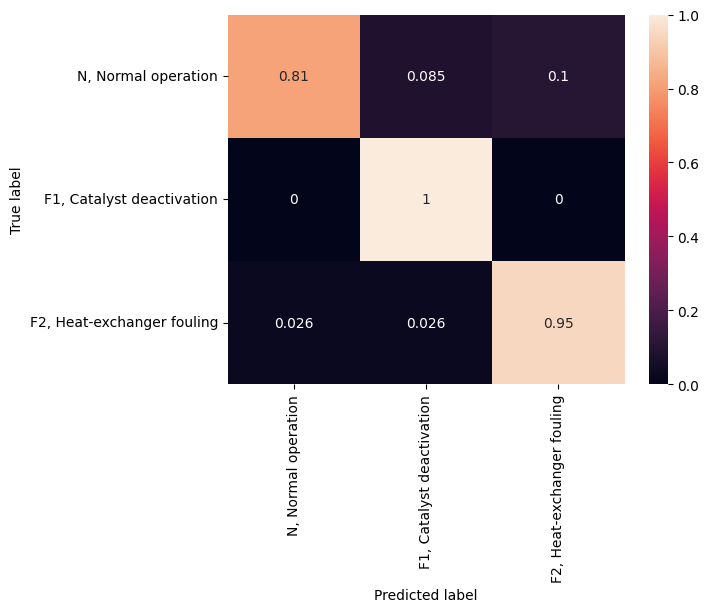

In [21]:
label_list = pipeline.steps[4][1].classes_
cf = confusion_matrix(test_labels, preds, labels=label_list).astype(float)
for i in range(len(cf)):
    cf[i] = [x / cf[i].sum() for x in cf[i]]    
label_dict = {'1': 'F1, Catalyst deactivation', '2': 'F2, Heat-exchanger fouling', '3': 'F3, Dead-coolant flow measurement', '4': 'F4, Bias in reactor temperature measurement', '5': 'F5, Coolant valve stiction qF7', '6': 'F6, Step change in QF', '7': 'F7, Ramp change in CAF', '8': 'F8, Ramp change in TF', '9': 'F9, Ramp change in TCF', '0': 'N, Normal operation'}
# label_dict = {'1': 'I have command',  '2': 'All clear',  '3': 'Not clear', '4': 'Spread wings', '5': 'Fold wings', '6': 'Lock wings'}

text_labels = [label_dict[str(i)] for i in label_list]
sns.heatmap(cf, annot=True, xticklabels=text_labels, yticklabels=text_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [22]:
comte = explainers.OptimizedSearch(pipeline, timeseries, labels, silent=False, threads=1,num_distractors=2)

In [23]:
test_labels['label']


node_id       timestamp
node_2_331    0            0
node_2_6956   0            1
node_3_8627   0            0
node_2_12388  0            2
node_2_4711   0            1
                          ..
node_2_12035  0            2
node_2_6388   0            1
node_3_2677   0            2
node_2_3861   0            1
node_3_3871   0            0
Name: label, Length: 230, dtype: int64

In [25]:
### TEST CASE 1
### True: 2 All clear, Predicted: 3 Not clear

true_select = 0 #UPDATE HERE FOR OTHER CLASSES
pred_select = 2 #UPDATE HERE FOR OTHER CLASSES
# print(test_labels['label'].values)
# print(preds)
indices_test = []
for idx, (true, pred, node_id) in enumerate(zip(test_labels['label'].values, preds, test_labels['label'].index.get_level_values('node_id'))):
    # if(true!=pred):
    #     print(idx,true,pred)
    if true ==  true_select and pred == pred_select:
        indices_test.append([node_id,idx])
print(indices_test)


[['node_2_9382', 58], ['node_2_9536', 62], ['node_3_5368', 71], ['node_3_845', 89], ['node_3_827', 112], ['node_2_9596', 122]]


In [ ]:
indices_test[0][0]

'node_3_5401'

2024-02-27 19:36:09,201 INFO    Working on turning label from 2 to 0
2024-02-27 19:36:10,838 INFO    Finished constructing per class kdtree
2024-02-27 19:36:10,839 INFO    Returning distractors ['node_2_9396', 'node_2_9351']
2024-02-27 19:36:10,839 INFO    Trying distractor 1 / 2
2024-02-27 19:36:10,853 INFO    Current probas: [[0.33 0.23 0.44]]
2024-02-27 19:36:10,854 INFO    Trying distractor 2 / 2
2024-02-27 19:36:10,867 INFO    Current probas: [[0.33 0.23 0.44]]
2024-02-27 19:36:10,868 INFO    Used greedy search for node_2_9382
2024-02-27 19:36:10,880 INFO    Working on turning label from 2 to 0
2024-02-27 19:36:10,881 INFO    Returning distractors ['node_2_9396', 'node_2_9351']
2024-02-27 19:36:10,881 INFO    Trying distractor 1 / 2
2024-02-27 19:36:10,895 INFO    Current probas: [[0.33 0.23 0.44]]
2024-02-27 19:36:11,071 INFO    Best column: riser.outlet.P, best case: 0.38
/Users/omkar/Projects/forks/CoMTE/explainers.py:104: UserWarning: FigureCanvasAgg is non-interactive, and th

###########
['Water.level']
###########


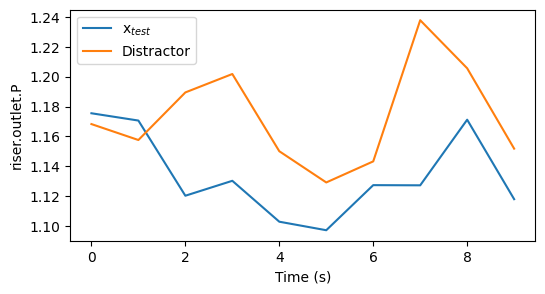

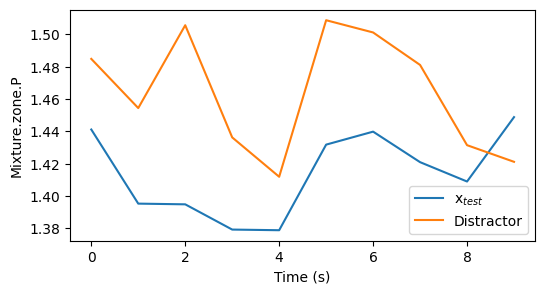

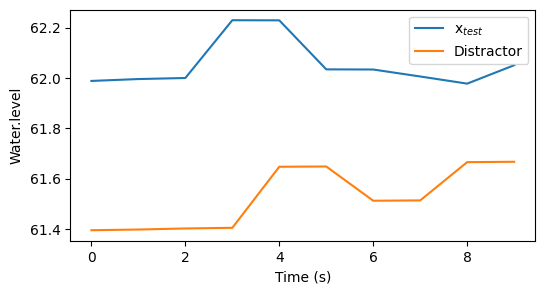

In [26]:
x_test = test_timeseries.loc[['node_2_9382'], :, :]
explanation = comte.explain(x_test,to_maximize=true_select,savefig=False) 
print('###########') 
print(explanation)
print('###########')
chime.success()